
# Neural Networks Demo 

This notebook is designed to **match the narrative** in the two lecture decks:

- *Neural Networks Part 1*: logistic unit → network, forward propagation, vectorization, supervised learning   
- *Neural Networks Part 2*: activations, initialization, computation graph, backpropagation, gradient descent   

We will use the **Ionosphere** dataset (binary classification: *good* vs *bad* radar returns) as in the original material. 

---

## Learning goals 

1. **A neuron = logistic unit**: $z=w^Tx+b$, $a=\sigma(z)$  
2. **A network = stacked neurons**: 
   $$
   Z^{[l]} = W^{[l]}A^{[l-1]} + b^{[l]}, \quad A^{[l]} = g^{[l]}(Z^{[l]})
   $$
3. **Why nonlinearity matters** (activation functions).
4. **Why initialization matters** (symmetry breaking).
5. **Backprop in one slide**: gradients flow backward via the chain rule.
6. **Practical workflow**: baseline model → neural net → evaluation and visualization.




## 0) Setup

We will use:
- `numpy`, `pandas` for data handling  
- `matplotlib` for plotting  
- `scikit-learn` for models + metrics  


In [69]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, precision_recall_curve, auc, classification_report
)

np.random.seed(42)

def set_figsize(w=8, h=5):
    plt.figure(figsize=(w, h))


## 1) Load the Ionosphere Dataset

The Ionosphere dataset contains radar measurements collected from a **16-antenna phased-array radar system** located in Goose Bay, Labrador.

Each data point represents **one radar return**.

The task is to classify whether the returned signal indicates **structured ionospheric plasma** or not.

---

# What is the Ionosphere?

The **ionosphere** is a region of Earth's upper atmosphere that becomes electrically charged due to solar radiation.

It contains:
- Free electrons  
- Positive ions  
- Plasma structures  

It extends approximately from **60 km to 1000 km above Earth's surface**.

### Atmospheric Structure (NASA)

![Earth's atmospheric layers including ionosphere](https://www.nasa.gov/wp-content/uploads/2023/03/463940main_atmosphere-layers2_full.jpg?w=1041)

*Source: NASA — Earth’s Atmospheric Layers*

The ionosphere overlaps mainly with:
- The **upper mesosphere**
- The **thermosphere**

Its electron density varies with:
- Time of day  
- Solar activity  
- Geomagnetic disturbances  

---

# How Radio Waves Interact with the Ionosphere

High-frequency (HF) radio waves can be **refracted or reflected** by the ionosphere depending on its plasma structure and electron density.

### Radio Wave Refraction / Reflection (NASA SVS)

![Radio wave refraction/reflection on a simplified ionosphere model (NASA SVS)](https://svs.gsfc.nasa.gov/vis/a000000/a005200/a005240/polar.propagation.basic.sample.1920x1080.png)

*Source: NASA Scientific Visualization Studio*

This principle allows:

- Long-distance radio communication
- Over-the-horizon radar systems
- Monitoring of ionospheric disturbances

---

# What Are We Measuring?

The radar system:

1. Transmits a high-frequency pulse upward  
2. The pulse interacts with ionized plasma  
3. The signal may:
   - Reflect back (structured ionosphere)
   - Pass through (weak or no structure)

The returned signal is processed using an **autocorrelation function** across multiple pulse delays.

Each pulse produces a **complex-valued measurement**:

$$
z_k = a_k + i b_k
$$

where:
- $a_k$ = real component  
- $b_k$ = imaginary component  

Thus, we do **not measure the ionosphere directly**.

We measure:

> The electromagnetic response of the ionosphere to transmitted radar pulses.

---

# Why Is This Important?

Understanding ionospheric structure is critical for:

- **Radio communication reliability**
- **GPS positioning accuracy**
- **Satellite communication**
- **Space weather monitoring**
- **Solar storm impact prediction**
- **Aviation and military navigation**
- **Over-the-horizon radar**

Disturbances in the ionosphere can:

- Bend radio waves  
- Block communication  
- Introduce GPS positioning errors  
- Affect infrastructure during strong solar events  

Machine learning helps automatically classify radar returns and detect plasma irregularities.

---

# Dataset Structure

Each sample contains:

- **34 numeric features**
- **1 binary class label**
- Total dimension per sample: 35 columns

The 34 features come from:

- **17 radar pulses**
- 2 values per pulse (real & imaginary components)

---

## Feature Overview

| Columns (0-based index) | Feature Group | Description | Type |
|--------------------------|--------------|-------------|------|
| 0–33 | Radar signal features | 17 pulses × 2 values per pulse (real & imaginary components of autocorrelation function) | Numeric |
| 34 | Class label | `g` = good radar return (structured ionosphere) <br> `b` = bad radar return (no significant reflection) | Categorical |

---

# Mathematical Representation

For $k = 1, \dots, 17$:

$$
z_k = a_k + i b_k
$$

The full feature vector becomes:

$$
X = [a_1, b_1, a_2, b_2, \dots, a_{17}, b_{17}] \in \mathbb{R}^{34}
$$

The classification target:

- `g` → 1  (structured ionospheric reflection)
- `b` → 0  (no significant reflection)

---

# Goose Bay HF Radar Antenna Array

![Goose Bay HF Radar Antenna Array](https://hgss.copernicus.org/articles/12/77/2021/hgss-12-77-2021-f01-web.png)

*Source: Historical Geoscience and Space Sciences (HGSS)*

---

# Implementation Note

If you run this in **Google Colab** and the file `Ionosphere.csv` is not found locally,
the notebook will automatically download the raw dataset from the UCI repository as a fallback.

---


In [70]:

from pathlib import Path
import urllib.request

LOCAL_PATH = Path("Ionosphere.csv")  # expected name in this course material 
UCI_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"

def load_ionosphere():
    if LOCAL_PATH.exists():
        # Your course file is a CSV; we try standard reading first.
        try:
            df = pd.read_csv(LOCAL_PATH)
            return df, "local_csv"
        except Exception:
            pass

    # Fallback: download raw UCI data (comma-separated, no header)
    print("Local Ionosphere.csv not found/failed to read; downloading from UCI...")
    raw = urllib.request.urlopen(UCI_URL).read().decode("utf-8").strip().splitlines()
    rows = [line.split(",") for line in raw]
    df = pd.DataFrame(rows)
    return df, "uci_raw"

df_raw, source = load_ionosphere()
print("Source:", source)
print("Shape:", df_raw.shape)
df_raw.head()


Local Ionosphere.csv not found/failed to read; downloading from UCI...
Source: uci_raw
Shape: (351, 35)


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1,-0.03365,1,0.00485,1,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1,-0.45161,1,1,0.71216,-1,0,0,...,0.90695,0.51613,1,1,-0.20099,0.25682,1,-0.32382,1,b
4,1,0,1,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g



### 1.1) Clean parsing and extract $X$ and $y$

The UCI raw file has **34 features + 1 label** with no header.
Your local `Ionosphere.csv` may already have headers; we handle both cases.

We'll produce:
- feature matrix $X \in \mathbb{R}^{m \times n}$
- label vector $y \in \{0,1\}^m$


In [71]:

def parse_ionosphere(df, source):
    df = df.copy()

    if source == "uci_raw":
        # 35 columns: 34 features + label
        df.columns = [f"x{i+1}" for i in range(df.shape[1]-1)] + ["label"]
    else:
        # If label column is not obvious, guess it:
        if "label" not in df.columns:
            # Try common cases: last column or named "Class" / "class"
            if df.columns[-1].lower() in ["label", "class"]:
                df = df.rename(columns={df.columns[-1]: "label"})
            else:
                df = df.rename(columns={df.columns[-1]: "label"})
        # Ensure feature columns are all but label
        feature_cols = [c for c in df.columns if c != "label"]
        # If there are non-numeric columns besides label, attempt coercion
        for c in feature_cols:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Ensure numeric features
    feature_cols = [c for c in df.columns if c != "label"]
    for c in feature_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Drop rows with missing (should be none for this dataset)
    df = df.dropna(axis=0).reset_index(drop=True)

    # Label mapping
    y_raw = df["label"].astype(str).str.strip().str.lower()
    y = (y_raw == "g").astype(int).to_numpy()

    X = df[feature_cols].to_numpy(dtype=float)
    return df, X, y, feature_cols

df, X, y, feature_cols = parse_ionosphere(df_raw, source)

print("Parsed shape X:", X.shape, " y:", y.shape)
print("Class balance (good=1):", y.mean().round(3))
df.head()


Parsed shape X: (351, 34)  y: (351,)
Class balance (good=1): 0.641


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x26,x27,x28,x29,x30,x31,x32,x33,x34,label
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g



## 2) Quick EDA (a few high-signal plots)

We keep this compact but informative:
- class balance
- a small set of feature distributions
- correlation structure (heatmap)
- PCA projection (2D) as a *visual handle* for decision boundaries later


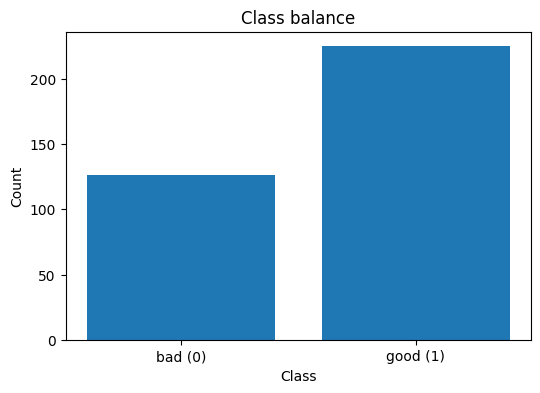

In [72]:

# Class balance
set_figsize(6,4)
plt.hist(y, bins=[-0.5,0.5,1.5], rwidth=0.8)
plt.xticks([0,1], ["bad (0)", "good (1)"])
plt.title("Class balance")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


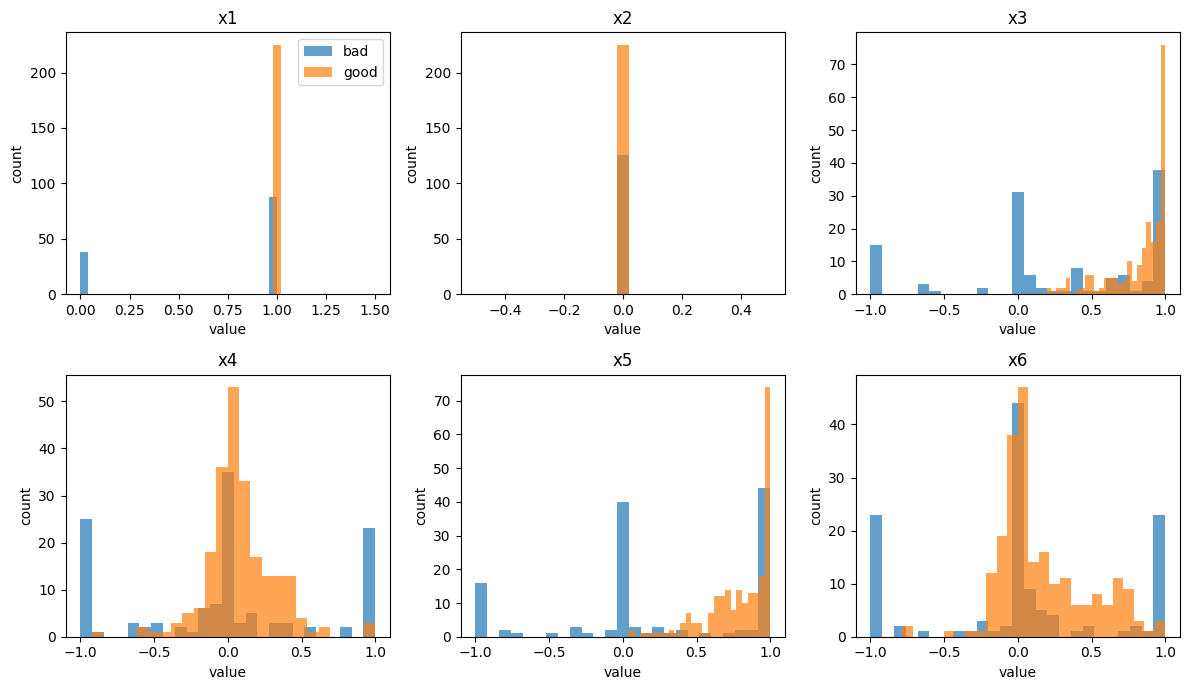

In [73]:

# Feature distributions for a few selected features
sel = list(range(0, min(6, X.shape[1])))
fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.ravel()
for ax, j in zip(axes, sel):
    ax.hist(X[y==0, j], bins=25, alpha=0.7, label="bad")
    ax.hist(X[y==1, j], bins=25, alpha=0.7, label="good")
    ax.set_title(f"{feature_cols[j]}")
    ax.set_xlabel("value")
    ax.set_ylabel("count")
axes[0].legend()
plt.tight_layout()
plt.show()


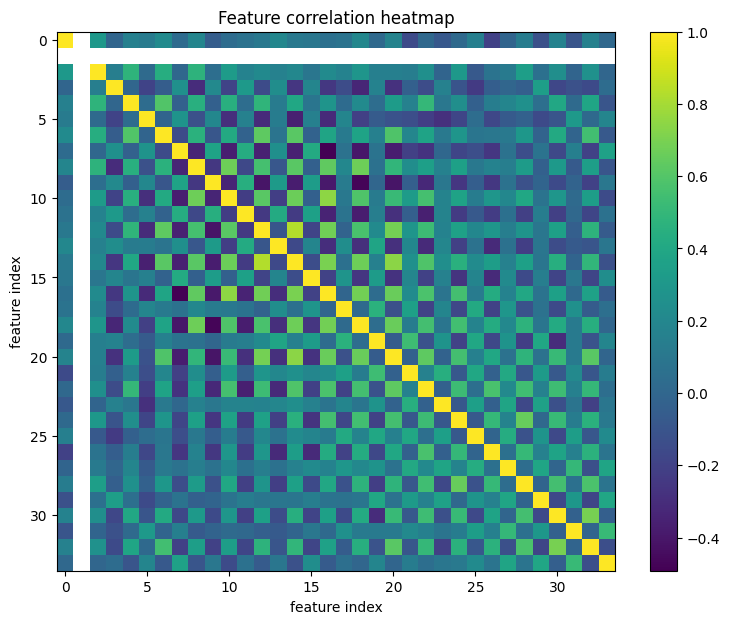

In [74]:

# Correlation heatmap (scaled for readability)
X_df = pd.DataFrame(X, columns=feature_cols)
corr = X_df.corr()

set_figsize(9,7)
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.title("Feature correlation heatmap")
plt.xlabel("feature index")
plt.ylabel("feature index")
plt.show()


## PCA Projection to 2D (Visualization Only)

The Ionosphere dataset has **34 dimensions**, which makes direct visualization impossible.

To gain intuition about the structure of the data, we use **Principal Component Analysis (PCA)** to project the feature matrix

$$
X \in \mathbb{R}^{34}
$$

onto a 2-dimensional subspace.

Important:

- This projection is used **only for visualization**
- It does **not necessarily preserve class separability**
- The best classification model will still be trained in the **full 34-dimensional space**

PCA finds directions (principal components) that maximize variance in the data.
We will visualize the first two principal components (PC1 and PC2).


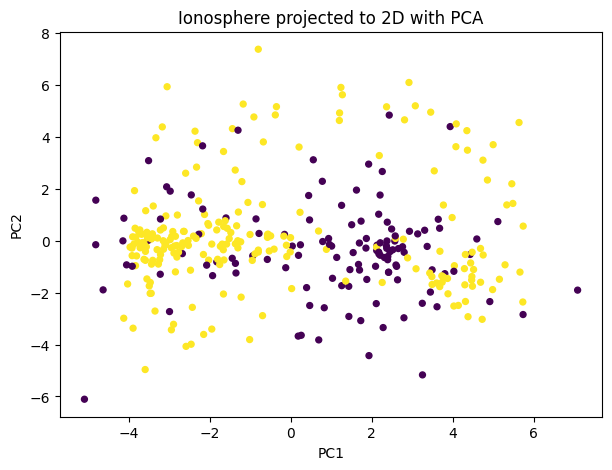

Explained variance ratio (PC1, PC2): [0.267 0.128]


In [75]:

# PCA 2D projection (for visualization, not for the best model)
pca2 = PCA(n_components=2, random_state=42)
X2 = pca2.fit_transform(StandardScaler().fit_transform(X))

set_figsize(7,5)
plt.scatter(X2[:,0], X2[:,1], c=y, s=18)
plt.title("Ionosphere projected to 2D with PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("Explained variance ratio (PC1, PC2):", pca2.explained_variance_ratio_.round(3))



## 3) Recap: the logistic unit (a single neuron)

A **single neuron** for binary classification is logistic regression:

- **pre-activation**: $z = w^T x + b$  
- **activation**: $a = \sigma(z) = \dfrac{1}{1+e^{-z}}$  
- **prediction**: $\hat{y} = \mathbb{1}[a \ge 0.5]$

Loss (binary cross entropy) for one example:
$$
\mathcal{L}(\hat{y}, y) = -y\log(\hat{y}) - (1-y)\log(1-\hat{y})
$$

We'll train a logistic regression baseline and evaluate it.


In [76]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500))
])

logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)
proba = logreg.predict_proba(X_test)[:,1]

print("LogReg accuracy:", accuracy_score(y_test, pred).round(3))
print("LogReg F1:", f1_score(y_test, pred).round(3))


LogReg accuracy: 0.898
LogReg F1: 0.923


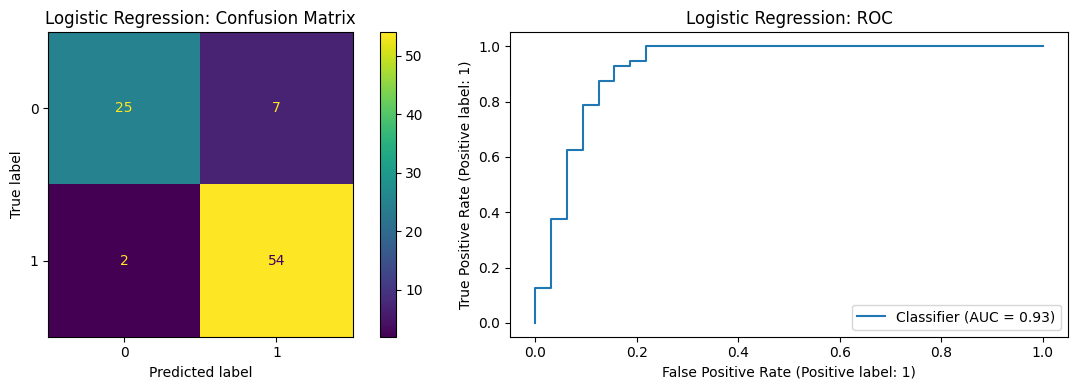

In [77]:

# Confusion matrix + ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=axes[0])
axes[0].set_title("Logistic Regression: Confusion Matrix")

RocCurveDisplay.from_predictions(y_test, proba, ax=axes[1])
axes[1].set_title("Logistic Regression: ROC")

plt.tight_layout()
plt.show()


## 4) From one neuron to a neural network

A *fully-connected* (dense) neural network stacks multiple layers of neurons,
where each neuron in one layer is connected to **all neurons in the next layer**.

### Fully Connected Network Example (MLP)

![Multilayer Perceptron (fully connected) diagram](https://upload.wikimedia.org/wikipedia/commons/a/a9/Perceptron_4layers.png)

*Source: Wikimedia Commons — “Perceptron_4layers.png” (public domain).*

---

### Forward propagation (vectorized)

Let:
- $A^{[0]} = X \in \mathbb{R}^{n \times m}$ be the input matrix (features × examples)

For each layer $l = 1, \dots, L$:

$$
Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}, 
\quad
A^{[l]} = g^{[l]}(Z^{[l]})
$$

Shapes (typical convention):

- $W^{[l]} \in \mathbb{R}^{n_l \times n_{l-1}}$
- $b^{[l]} \in \mathbb{R}^{n_l \times 1}$
- $A^{[l]} \in \mathbb{R}^{n_l \times m}$

---

### Key idea

- Logistic regression is just the special case **with no hidden layers**.
- Hidden layers + nonlinear activation functions enable  
  **nonlinear decision boundaries**.
- Each layer performs a linear transformation followed by a nonlinearity.



## 5) Activation functions (why nonlinearity matters)

Common choices (as in the slides) fileciteturn0file1:

- **Sigmoid**: $\sigma(z)=\dfrac{1}{1+e^{-z}}$  
- **tanh**: $\tanh(z)$  
- **ReLU**: $\max(0, z)$  
- **Softmax** (multiclass): $\text{softmax}(z)_k = \dfrac{e^{z_k}}{\sum_j e^{z_j}}$

Below we plot them to connect the formulas to intuition.


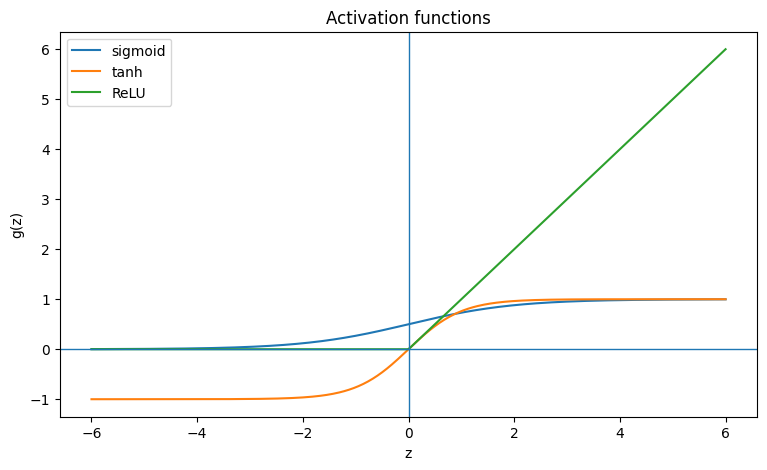

In [78]:

z = np.linspace(-6, 6, 400)

sigmoid = 1/(1+np.exp(-z))
tanh = np.tanh(z)
relu = np.maximum(0, z)

set_figsize(9,5)
plt.plot(z, sigmoid, label="sigmoid")
plt.plot(z, tanh, label="tanh")
plt.plot(z, relu, label="ReLU")
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.title("Activation functions")
plt.xlabel("z")
plt.ylabel("g(z)")
plt.legend()
plt.show()



## 6) Why random initialization?

If all weights start as **zeros**, many neurons in the same layer receive the same gradients and remain identical.
This is the **symmetry problem**.

Random initialization breaks symmetry and lets neurons learn different features.

We can *visualize* this by comparing the first-layer weight matrix $W^{[1]}$ under:
- zero initialization (conceptual)
- random initialization (what we actually use)


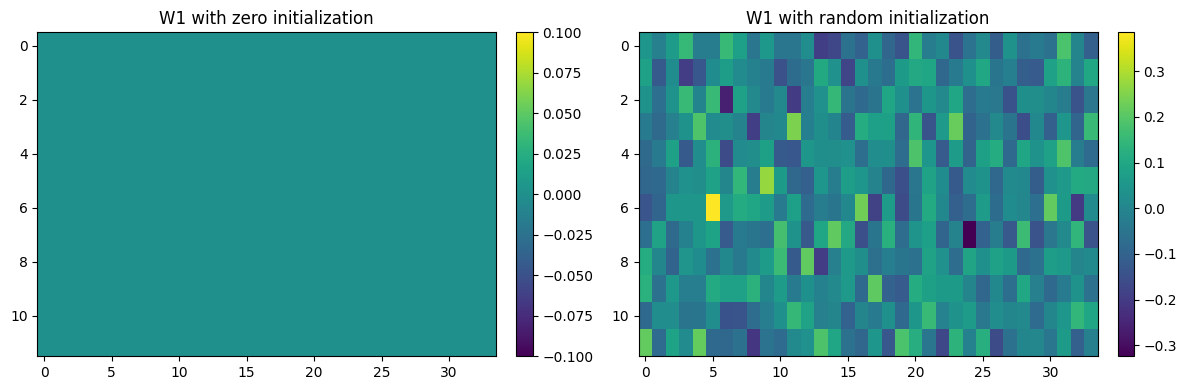

In [79]:

# Visualize two initializations for W1 (for illustration)
n_in = X.shape[1]
n_hidden = 12

W_zero = np.zeros((n_hidden, n_in))
W_rand = np.random.normal(0, 0.1, size=(n_hidden, n_in))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
im0 = axes[0].imshow(W_zero, aspect="auto")
axes[0].set_title("W1 with zero initialization")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(W_rand, aspect="auto")
axes[1].set_title("W1 with random initialization")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


## Symmetry in Practice 

`MLPClassifier` initializes weights randomly by default.

To illustrate *why* this matters, we compare:
- a normal MLP (random initialization)
- a forced **zero-initialized** first layer

With zero initialization, neurons start identical and receive identical updates (symmetry), so the hidden layer cannot diversify.


Final test accuracy (random init): 0.9204545454545454
Final test accuracy (zero W1 init): 0.8977272727272727

Symmetry diagnostics (zero W1 init):
Neuron 0 == Neuron 1 ? False
Neuron 1 == Neuron 2 ? False
Approx. unique hidden neurons: 12 / 12


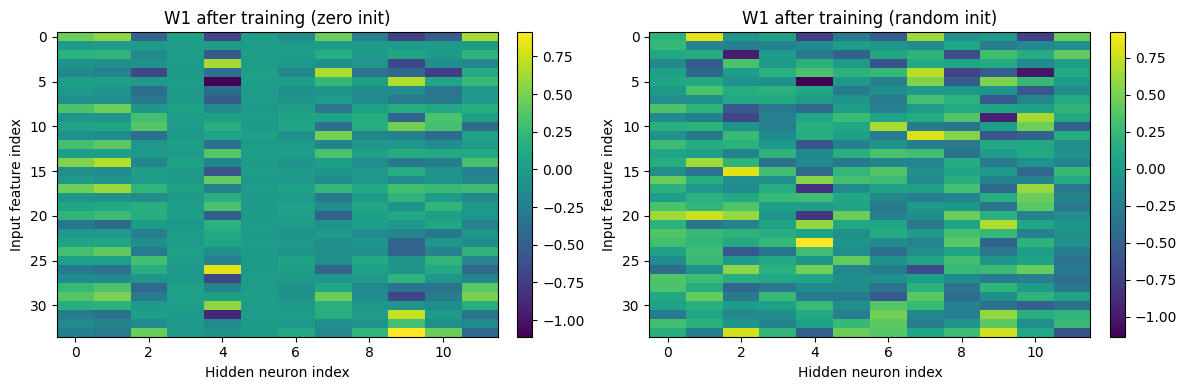

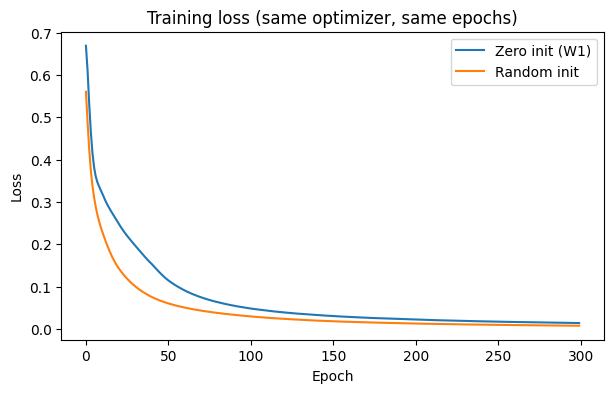

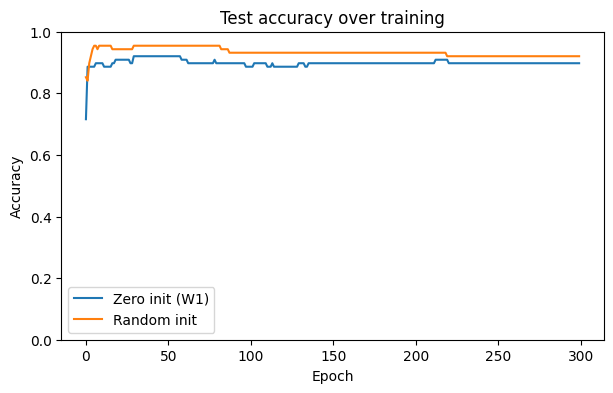

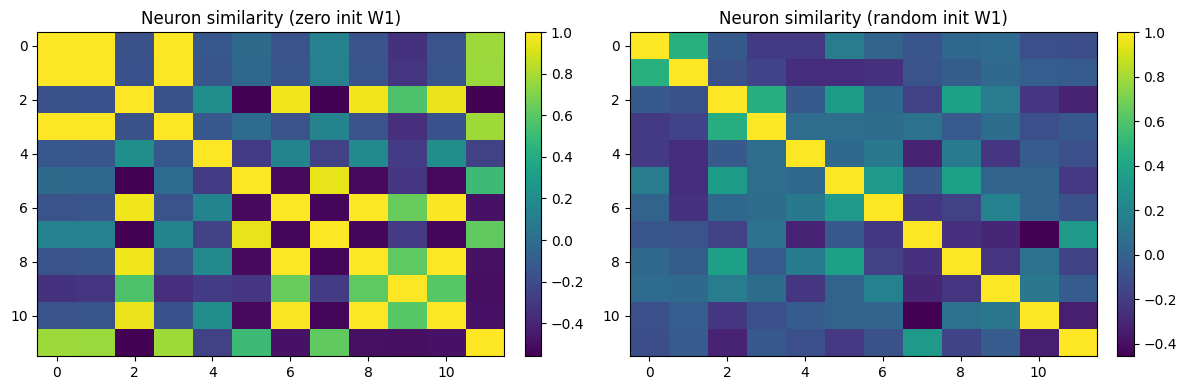

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

np.random.seed(42)

# -------------------------
# 0) Scaling (same for both)
# -------------------------
scaler = StandardScaler()
Xtr = scaler.fit_transform(X_train)
Xte = scaler.transform(X_test)
classes = np.unique(y_train)

# -------------------------
# 1) Helper: build MLP (same config for both)
# -------------------------
def make_mlp(random_state=42):
    return MLPClassifier(
        hidden_layer_sizes=(12,),
        activation="relu",
        solver="sgd",              # SAME optimizer
        learning_rate_init=0.05,
        momentum=0.9,
        nesterovs_momentum=True,
        alpha=0.0,
        max_iter=1,                # we control epochs manually
        warm_start=True,
        random_state=random_state
    )

def init_shapes(clf):
    # one call so sklearn creates coefs_/intercepts_ with correct shapes
    clf.partial_fit(Xtr, y_train, classes=classes)

def forward_hidden(W1, b1, X):
    # hidden pre-activation and activation (ReLU)
    Z = X @ W1 + b1
    return np.maximum(0, Z)

# -------------------------
# 2) Create two identical models
# -------------------------
clf_rand = make_mlp(42)
clf_zero = make_mlp(42)  # same seed/config; we will overwrite W1 for this one

init_shapes(clf_rand)
init_shapes(clf_zero)

# sklearn shapes: coefs_[0] is (n_features, n_hidden), coefs_[1] is (n_hidden, 1)
# IMPORTANT: Keep output layer identical between the two models to isolate the effect of W1 init
W2_shared = clf_rand.coefs_[1].copy()
b2_shared = clf_rand.intercepts_[1].copy()
clf_zero.coefs_[1][:] = W2_shared
clf_zero.intercepts_[1][:] = b2_shared

# Now define initializations:
# Random init: keep clf_rand's existing W1,b1 (random)
# Zero init: set ONLY first layer to zeros (symmetry trigger)
clf_zero.coefs_[0][:] = 0.0
clf_zero.intercepts_[0][:] = 0.0

# -------------------------
# 3) Train both for same number of epochs
# -------------------------
EPOCHS = 300

loss_rand, loss_zero = [], []
acc_rand, acc_zero = [], []

for _ in range(EPOCHS):
    clf_rand.partial_fit(Xtr, y_train)
    clf_zero.partial_fit(Xtr, y_train)

    loss_rand.append(clf_rand.loss_)
    loss_zero.append(clf_zero.loss_)

    acc_rand.append(accuracy_score(y_test, clf_rand.predict(Xte)))
    acc_zero.append(accuracy_score(y_test, clf_zero.predict(Xte)))

print("Final test accuracy (random init):", acc_rand[-1])
print("Final test accuracy (zero W1 init):", acc_zero[-1])

# -------------------------
# 4) Symmetry check: are hidden neurons identical?
# -------------------------
W1z = clf_zero.coefs_[0]      # (n_features, n_hidden)
b1z = clf_zero.intercepts_[0] # (n_hidden,)

# Compare a few columns (hidden neurons)
same01 = np.allclose(W1z[:,0], W1z[:,1]) and np.isclose(b1z[0], b1z[1])
same12 = np.allclose(W1z[:,1], W1z[:,2]) and np.isclose(b1z[1], b1z[2])

# Count unique hidden neurons (rounded)
unique_cols = np.unique(np.round(W1z, 10).T, axis=0).shape[0]

print("\nSymmetry diagnostics (zero W1 init):")
print("Neuron 0 == Neuron 1 ?", same01)
print("Neuron 1 == Neuron 2 ?", same12)
print("Approx. unique hidden neurons:", unique_cols, "/", W1z.shape[1])

# -------------------------
# 5) Visualizations
# -------------------------
W1r = clf_rand.coefs_[0]

# 5.1 W1 heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
im0 = axes[0].imshow(W1z, aspect="auto")
axes[0].set_title("W1 after training (zero init)")
axes[0].set_xlabel("Hidden neuron index")
axes[0].set_ylabel("Input feature index")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(W1r, aspect="auto")
axes[1].set_title("W1 after training (random init)")
axes[1].set_xlabel("Hidden neuron index")
axes[1].set_ylabel("Input feature index")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# 5.2 Loss curves
plt.figure(figsize=(7,4))
plt.plot(loss_zero, label="Zero init (W1)")
plt.plot(loss_rand, label="Random init")
plt.title("Training loss (same optimizer, same epochs)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# 5.3 Test accuracy curves
plt.figure(figsize=(7,4))
plt.plot(acc_zero, label="Zero init (W1)")
plt.plot(acc_rand, label="Random init")
plt.title("Test accuracy over training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.show()

# 5.4 Hidden-neuron similarity (correlation between neurons/columns)
def neuron_similarity(W):
    # corr between columns; guard against NaNs if a column is constant
    C = np.corrcoef(W.T)
    C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
    return C

Cz = neuron_similarity(W1z)
Cr = neuron_similarity(W1r)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
im0 = axes[0].imshow(Cz, aspect="auto")
axes[0].set_title("Neuron similarity (zero init W1)")
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

im1 = axes[1].imshow(Cr, aspect="auto")
axes[1].set_title("Neuron similarity (random init W1)")
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()



## 7) Train a neural network on Ionosphere (practical)

We will use `sklearn.neural_network.MLPClassifier` as a clean, *engineering-friendly* implementation of a fully-connected network.

### What we control
- hidden layer sizes (capacity)
- activation (`relu` or `tanh`)
- regularization (`alpha`)
- learning rate schedule (via solver parameters)

### What we monitor
- loss curve (training)
- test metrics: accuracy + F1
- confusion matrix


In [81]:

def train_mlp(hidden=(32, 16), activation="relu", alpha=1e-4, max_iter=400, random_state=42):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(
            hidden_layer_sizes=hidden,
            activation=activation,
            alpha=alpha,
            solver="adam",
            learning_rate_init=1e-3,
            max_iter=max_iter,
            early_stopping=True,
            n_iter_no_change=800,
            random_state=random_state
        ))
    ])
    model.fit(X_train, y_train)
    return model

mlp = train_mlp(hidden=(32, 16), activation="relu", alpha=1e-4)
pred = mlp.predict(X_test)
proba = mlp.predict_proba(X_test)[:,1]

print("MLP accuracy:", accuracy_score(y_test, pred).round(3))
print("MLP F1:", f1_score(y_test, pred).round(3))


MLP accuracy: 0.955
MLP F1: 0.966


c:\Users\Simon\.conda\envs\matmod-2022-test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


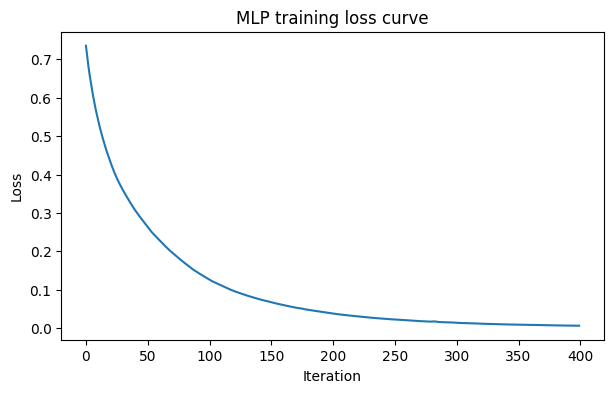

In [82]:

# Loss curve (from underlying classifier)
loss_curve = mlp.named_steps["clf"].loss_curve_

set_figsize(7,4)
plt.plot(loss_curve)
plt.title("MLP training loss curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()


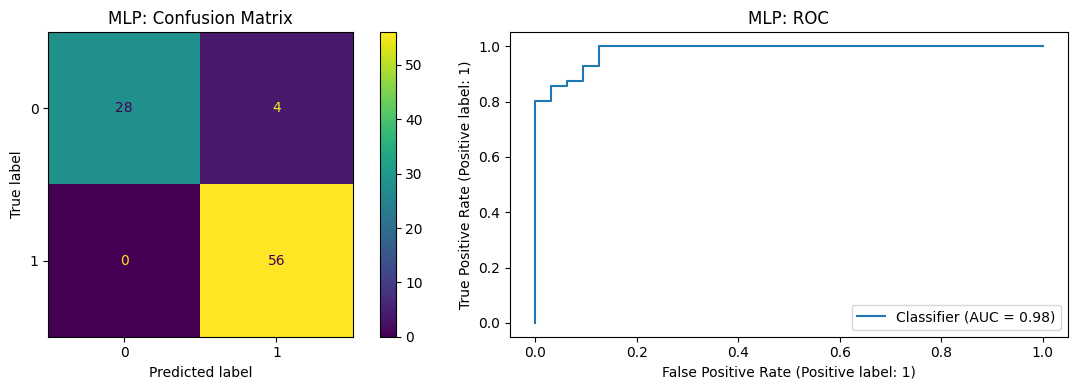

In [83]:

# Confusion matrix + ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=axes[0])
axes[0].set_title("MLP: Confusion Matrix")

RocCurveDisplay.from_predictions(y_test, proba, ax=axes[1])
axes[1].set_title("MLP: ROC")

plt.tight_layout()
plt.show()



## 8) Model comparison: capacity vs generalization

We will compare a small grid of networks:
- shallow vs deeper
- `tanh` vs `relu`

This is a controlled experiment: same split, same scaling, only architecture/activation changes.


In [84]:

configs = [
    {"hidden": (8,), "activation": "tanh"},
    {"hidden": (16,), "activation": "tanh"},
    {"hidden": (32,16), "activation": "tanh"},
    {"hidden": (8,), "activation": "relu"},
    {"hidden": (16,), "activation": "relu"},
    {"hidden": (32,16), "activation": "relu"},
]

rows = []
models = {}
for cfg in configs:
    model = train_mlp(hidden=cfg["hidden"], activation=cfg["activation"], alpha=1e-4, max_iter=1000, random_state=42)
    yhat = model.predict(X_test)
    acc = accuracy_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    key = f"{cfg['activation']} {cfg['hidden']}"
    models[key] = model
    rows.append({"model": key, "accuracy": acc, "f1": f1})

res = pd.DataFrame(rows).sort_values(["f1", "accuracy"], ascending=False).reset_index(drop=True)
res


c:\Users\Simon\.conda\envs\matmod-2022-test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Simon\.conda\envs\matmod-2022-test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Simon\.conda\envs\matmod-2022-test\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,model,accuracy,f1
0,"relu (32, 16)",0.954545,0.965517
1,"relu (8,)",0.931818,0.947368
2,"relu (16,)",0.909091,0.931034
3,"tanh (16,)",0.897727,0.924370
4,"tanh (32, 16)",0.886364,0.918033
5,"tanh (8,)",0.852273,0.888889


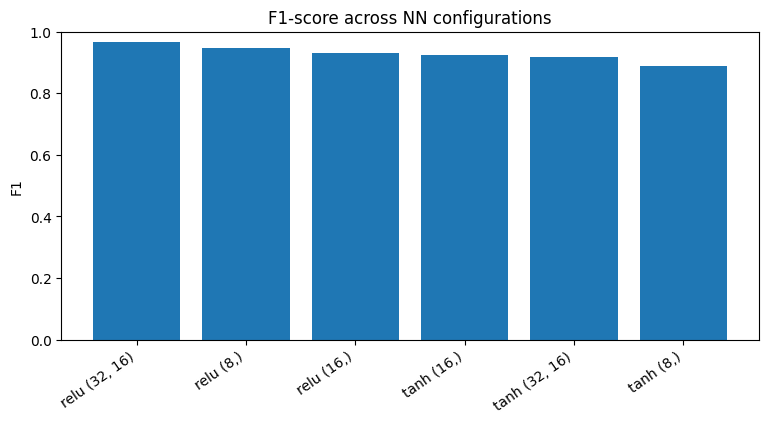

In [85]:

# Bar plot comparison
set_figsize(9,4)
plt.bar(res["model"], res["f1"])
plt.title("F1-score across NN configurations")
plt.ylabel("F1")
plt.xticks(rotation=35, ha="right")
plt.ylim(0, 1.0)
plt.show()



## 9) Visual intuition: decision boundary in 2D (PCA projection)

With 34 features we cannot draw the true decision boundary.
A reasonable **visual proxy**:

1. Project $X$ to 2D with PCA (for plotting).
2. Train a small MLP on the **2D representation**.
3. Plot the learned boundary + data points.

This helps students *see* that neural nets can learn nonlinear separation.


In [86]:

# Train/test in PCA space
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y, test_size=0.25, random_state=42, stratify=y
)

mlp_2d = MLPClassifier(hidden_layer_sizes=(16, 8), activation="tanh",
                      alpha=1e-4, solver="adam",
                      learning_rate_init=1e-3,
                      max_iter=2000, random_state=42)
mlp_2d.fit(X2_train, y2_train)

print("2D MLP (PCA space) accuracy:", accuracy_score(y2_test, mlp_2d.predict(X2_test)).round(3))


2D MLP (PCA space) accuracy: 0.852


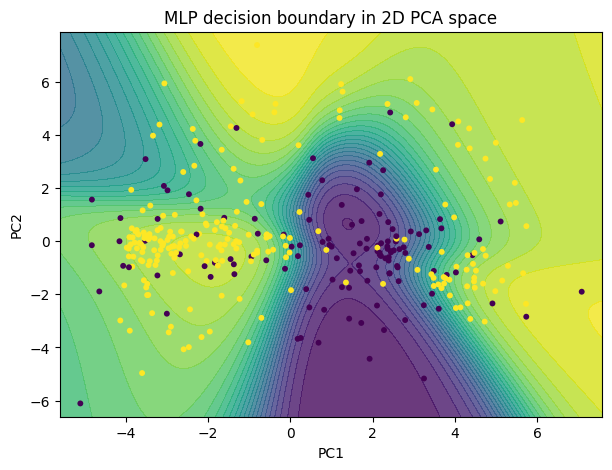

In [87]:

def plot_decision_boundary_2d(model, X2, y, title="Decision boundary"):
    # Create grid
    x_min, x_max = X2[:,0].min()-0.5, X2[:,0].max()+0.5
    y_min, y_max = X2[:,1].min()-0.5, X2[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model.predict_proba(grid)[:,1].reshape(xx.shape)

    set_figsize(7,5)
    plt.contourf(xx, yy, zz, levels=30, alpha=0.8)
    plt.scatter(X2[:,0], X2[:,1], c=y, s=18, edgecolors="none")
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

plot_decision_boundary_2d(mlp_2d, X2, y, title="MLP decision boundary in 2D PCA space")
